        Aerosol- und Nanotechnologie II | Florian Möller | Matr.-Nr. 4223486 | Abgabe: 01.05.22

# Task 1

The goal of this project is to design a CSTR reactor optimized to produce a given particle number distribution. 

The mass balance for the CSTR (continuous stirred tank reactor) with a volume $B$ and a flow $Q$ is given by 

$$
Q n(v)=Q n_{0}(v)+B\left(\begin{array}{c}
\text { net rate of formation } \\
\text { per unit volume }
\end{array}\right)-B\left(\begin{array}{c}
\text { rate of deposition } \\
\text { per unit volume }
\end{array}\right).
\label{eq:Massenbilanz}
$$

At steady state the mass balance ODE for a given initial aerosol distribution $n_{0}(v)$ can be simplified and is given by

$$
\frac{n_{0}}{\tau}=\frac{n}{\tau}+\frac{d(n q)}{d v}
$$

where $\tau = B / Q$ is the residence time, $n_0$ the particle distribution at the beginning, and n(v) the particle distribution, depending from the particle volume $v$. $q$ is a given variable, which is given by

$$
q=A v^{1 / 3}
$$

where $A = 0.1~\mathrm{m}^{2/3}$ is a constant variable.

The goals for the first Task is an discretization of the steady state coagulation for a CSTR.


For comparison, an analytical form is given by

$$
n(v)=\frac{1}{A v^{1 / 3}}\left\{\exp \left[\frac{3}{2} \frac{\left(v_{0}^{2 / 3}-v^{2 / 3}\right)}{A \tau}\right]\right\} \frac{N_{0}}{\tau} \quad\left(v>v_{0}\right).
\label{eq:Loesung_an}
$$

In [1]:
import numpy as np
import scipy.integrate
from matplotlib import pyplot as plt

In [7]:
# Parameters
dp_min = 0.5e-9                          # [m]
dp_max = 1000e-9                         # [m]
vp_min = np.pi * (dp_min)**3  /6          # [m^3] start-volume
vp_max = np.pi * (dp_max)**3  /6         # [m^3] max-volume

Q = 0.5 # volume flow [m^3/s]
B = 1000 # reactor volume [m^3]
tau = B/Q # Residence time [s]

# Initial particle size
dp_0 = 0.5e-9 # [m]
vp_0 = np.pi * (dp_0)**3  /6 # [m^3]
N_0 = 1e17 # number of particle at the beginning
A = 1e-1 # for q(v) (analytic solution)

# Initialization for vspan
vp_num = int(np.log(vp_max / vp_min) // np.log(2) + 2)  # number of iteration in x- direction
vp = np.zeros((vp_num))                                  
for i in range(vp_num): 
    vp[i] = vp_min * 2**i                               # geometric discretization from Hounslow et al. (1988) and Hounslow (1990b)
 

# Particle diameter span:
dp = ( 6 * vp/ np.pi)**(1/3.0)                          # Recalculating the Volume-Vector in a Diameter-Vector

## Analytic solution

First the analytic shape of the equation and the average diameter are calculated and the solution is shown graphically.

In [8]:
# functions
def fun_q(v): 
    return A * v **(1/3)  # definition from q(v) for the analytic soltution

def an_n(v): # definition from analytic solution as an function
    return (1/(A * v**(1/3.0))) * np.exp(
            (3/2.0) * (vp_0**(2/3.0) - v**(2/3.0))/(A * tau)
            ) * (N_0 / tau) 

# Function to compute the number average particle distribution
def dp_avg(n, dp):
    return np.sum(n * dp) / np.sum(n)

dp_avg = 3.50845075515007e-09 at B = 1000 m^3, tau = 2000.0 s


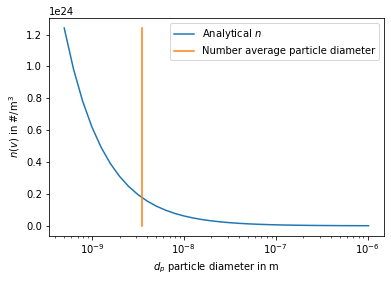

In [9]:
# Compute analytical solution:
n = an_n(vp)
# Next compute the number average particle diameter from the results:
dp_av = dp_avg(n, dp)

# Compute number average particle diameter
dp_av = dp_avg(n, dp)
print(f'dp_avg = {dp_av} at B = {B} m^3, tau = {tau} s')
plt.semilogx(dp, n, label=r'Analytical $n$')
plt.semilogx([dp_av, dp_av], [np.min(an_n(vp)), np.max(an_n(vp))], label='Number average particle diameter')

plt.ylabel(r'$n(v)$ in #/m$^3$')
plt.xlabel(r'$d_p$ particle diameter in m')
plt.legend()


## Numerical Solution

In the next step the numerical Solution will be calculated. The average diameter is calculated again.

In [10]:
v_min = vp_min

def dnqdv(v, nq):    
    q = fun_q(v)
    n = nq/q

    if v == vp_min:
        dnqdv = N_0/tau - n/tau
    else:
        dnqdv = - n/tau
    return dnqdv

# Initial value:
q = A * vp_min **(1/3.0)
y0 =  [N_0 / tau] # boundary condition for the differential equation

# Solver options
options = {'rtol': 1e-12,'atol': 1e-12}

# Initialise data containers.
res_nq_list = []  # nq variable to be integrated
res_v_list = []  # v indepedent variable
vpn = vp.copy()  # Volume span
rv = 0.0 
vp_min_n = vp_min
while rv < (vp_max * 0.99):
    # Solve the ivp:
    vpn = [vpn[0], vpn[1]]
    res = scipy.integrate.solve_ivp(dnqdv, vpn, y0, method='LSODA', **options)

    #Process results and save data:
    res_nq = res.y[0]
    res_v = res.t
    res_nq_list.extend(list(res_nq))
    res_v_list.extend(list(res_v))
    vp_min_n = res_v[-1]
    
    # Recompute particle bins
    vpn = vp.copy() 
    for i in range(vp_num): 
        vpn[i] = vp_min_n * 2**i 
    
    # Update the outer loop
    y0 = [res_nq[-1]]
    rv = res_v[-1] 

# Recompute the particle values
res_nq = np.array(res_nq_list)
res_v = np.array(res_v_list)
q_sol = A * res_v **(1/3.0)
res_n = res_nq / q_sol
res_dp = ( 6 * res_v/ np.pi)**(1/3.0)
dp_av = dp_avg(res_n, res_dp)
print(f'dp_av = {dp_av}')


dp_av = 3.5797253408464758e-09


At least to compare the numerical and the analytic solution, the results of both way a represented graphically.

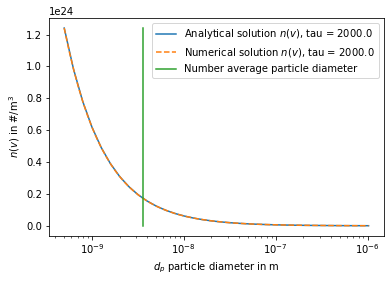

In [11]:
#plt.semilogx(vp, an_nq(vp), label='Analytical nq')
plt.semilogx(dp, an_n(vp), label=f'Analytical solution $n(v)$, tau = {tau}')
plt.semilogx(res_dp, res_n, '--', label=f'Numerical solution $n(v)$, tau = {tau}')
plt.semilogx([dp_av, dp_av], [np.min(an_n(vp)), np.max(an_n(vp))], label='Number average particle diameter')
plt.ylabel(r'$n(v)$ in #/m$^3$')
plt.xlabel(r'$d_p$ particle diameter in m')
plt.legend()
